In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
from operator import itemgetter
import copy
import numpy as np
np.random.seed(10)

Nous nous focalisons ici sur l'algorithme permettant de trouver le k-core contenant les mots-clefs.

# Python

## Algorithme en Python "simple"

In [2]:
def elbow_python(sorted_scores):
    sorted_scores = [np.array(i) for i in sorted_scores]

    first_point = sorted_scores[0]
    last_point =sorted_scores[-1]
    distances = []

    for index,point in enumerate(sorted_scores):
        point= np.array(point)
        d=np.cross(last_point-first_point,point-first_point)/np.linalg.norm(last_point-first_point)
        distances.append(abs(d))

    if np.max(distances)>0:
        x_elbow=sorted_scores[np.argmax(distances)]
    else :
        x_elbow=sorted_scores[0]

    return x_elbow

# et le reste des fonctions permettant d'extraire les keywords si nous le voulions (mais nous nous
# focaliserons sur le fonction elbow

def get_density(g):
    e = g.number_of_edges()
    v = g.number_of_nodes()

    if v !=0:
        density = abs(e)/(abs(v)*(abs(v)-1))
        return density
    else : 
        return None

def dens_method(g,k_core_decomp):
    D=[]
    for i in range(max(k_core_decomp.values())):
        nodes_indexes = [k for k, v in k_core_decomp.items() if v >i]
        g_small = g.subgraph(nodes_indexes)
        D.append(get_density(g_small))
    return elbow([i for i in enumerate(D)])[0]+1 # +1 as we started counting at zero

def get_keywords(g):
    k_core_decomp = nx.core_number(g) # replace by custom made function
    k_core_value_of_keywords = dens_method(g,k_core_decomp)
    keywords = [k for k, v in k_core_decomp.items() if v >= k_core_value_of_keywords]
    return keywords


# Cython

In [3]:
%load_ext Cython

Pour la suite, et afin de pouvoir appliquer Cython de façon approfondie sur une tâche simple, nous nous focalisons sur la fonction permettant de trouver le coude (elbow_python dans l'exemple Python "simple")

## Cython naïf

In [4]:
%%cython
import numpy as np
from libc.math cimport sqrt
import networkx as nx
from cpython cimport array
from array import array as pyarray
from libc.string cimport memcpy
import cython
from cython.parallel import prange

def naive_cython_elbow(sorted_scores):
    sorted_scores = [np.array(i) for i in sorted_scores]

    first_point = sorted_scores[0]
    last_point =sorted_scores[-1]
    distances = []

    for index,point in enumerate(sorted_scores):
        point= np.array(point)
        d=np.cross(last_point-first_point,point-first_point)/np.linalg.norm(last_point-first_point)
        distances.append(abs(d))

    if np.max(distances)>0:
        x_elbow=sorted_scores[np.argmax(distances)]
    else :
        x_elbow=sorted_scores[0]

    return x_elbow

## en remplaçant des fonctions numpy par des cdef (et en ajoutant les types)

In [5]:
%%cython
import numpy as np
from libc.math cimport sqrt
import networkx as nx
from cpython cimport array
from array import array as pyarray
from libc.string cimport memcpy
import cython
from cython.parallel import prange


cdef float cross_prod_vect( first_point, last_point,  point):
    cdef float Ax = (last_point[0] - first_point[0])
    cdef float Ay = (last_point[1]-first_point[1])
    cdef float Bx = (point[0]-first_point[0])
    cdef float By = (point[1]-first_point[1])
    cdef float result= Ax*By-Ay*Bx
    cdef float norm = sqrt(Ax*Ax+Ay*Ay)
    return result/norm
    

cdef float cross_prod(float Ax, float Ay, float Bx, float By):
    cdef float result= Ax*By-Ay*Bx
    cdef float norm = sqrt(Ax*Ax+Ay*Ay)
    return result/norm

cdef float density_with_e_v(float e, float v):
    return abs(e)/(abs(v)*(abs(v)-1))   

cpdef cdef_elbow(sorted_scores):
    cdef int elbow_point
    cdef double[:] first_point = sorted_scores[0]
    cdef double[:] last_point = sorted_scores[-1]
    cdef int i # pour optimiser la boucle
    cdef double[:] Y = np.zeros(len(sorted_scores))

    for i in range(len(sorted_scores)):
        point = sorted_scores[i]
        d = cross_prod_vect(first_point,last_point,point)
        Y[i]=abs(d)
        
    if np.max(Y)>0:
        x_elbow=sorted_scores[np.argmax(Y)]
    else :
        x_elbow=sorted_scores[0]

    return x_elbow

# en ajoutant les memoryviews

In [6]:
%%cython
import numpy as np
from libc.math cimport sqrt
import networkx as nx
from cpython cimport array
from array import array as pyarray
from libc.string cimport memcpy
import cython
from cython.parallel import prange


cdef float cross_prod_vect(double[:] first_point, double[:] last_point,  double[:] point):
    cdef float Ax = (last_point[0] - first_point[0])
    cdef float Ay = (last_point[1]-first_point[1])
    cdef float Bx = (point[0]-first_point[0])
    cdef float By = (point[1]-first_point[1])
    cdef float result= Ax*By-Ay*Bx
    cdef float norm = sqrt(Ax*Ax+Ay*Ay)
    return result/norm
    

cdef float cross_prod(float Ax, float Ay, float Bx, float By):
    cdef float result= Ax*By-Ay*Bx
    cdef float norm = sqrt(Ax*Ax+Ay*Ay)
    return result/norm

cdef float density_with_e_v(float e, float v):
    return abs(e)/(abs(v)*(abs(v)-1))   

cpdef c_elbow_memoryviews(double[:, :] sorted_scores):

    cdef int elbow_point
    cdef double[:] first_point = sorted_scores[0]
    cdef double[:] last_point = sorted_scores[-1]
    cdef int i # pour optimiser la boucle
    cdef double[:] Y = np.zeros(len(sorted_scores))

    for i in range(len(sorted_scores)):
        point = sorted_scores[i]
        d = cross_prod_vect(first_point,last_point,point)
        Y[i]=abs(d)
        
    if np.max(Y)>0:
        x_elbow=sorted_scores[np.argmax(Y)]
    else :
        x_elbow=sorted_scores[0]
        

    return x_elbow


## en desactivant boundscheck, wraparound 
(nous devons faire en sorte qu'aucun index ne soit alors négatif)

In [7]:
%%cython
import numpy as np
from libc.math cimport sqrt
import networkx as nx
from cpython cimport array
from array import array as pyarray
from libc.string cimport memcpy
import cython
from cython.parallel import prange


cdef float cross_prod_vect(double[:] first_point, double[:] last_point,  double[:] point):
    cdef float Ax = (last_point[0] - first_point[0])
    cdef float Ay = (last_point[1]-first_point[1])
    cdef float Bx = (point[0]-first_point[0])
    cdef float By = (point[1]-first_point[1])
    cdef float result= Ax*By-Ay*Bx
    cdef float norm = sqrt(Ax*Ax+Ay*Ay)
    return result/norm
    

cdef float cross_prod(float Ax, float Ay, float Bx, float By):
    cdef float result= Ax*By-Ay*Bx
    cdef float norm = sqrt(Ax*Ax+Ay*Ay)
    return result/norm

cdef float density_with_e_v(float e, float v):
    return abs(e)/(abs(v)*(abs(v)-1))   

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef c_elbow_noboundscheck_nowraparound(double[:, :] sorted_scores):

    cdef int elbow_point
    cdef int N = sorted_scores.shape[0]
    cdef double[:] first_point = sorted_scores[0]
    cdef double[:] last_point = sorted_scores[N-1]
    cdef int i # pour optimiser la boucle
    cdef double[:] Y = np.zeros(N)

    for i in range(N):
        point = sorted_scores[i]
        d = cross_prod_vect(first_point,last_point,point)
        Y[i]=abs(d)
        
    if np.max(Y)>0:
        x_elbow=sorted_scores[np.argmax(Y)]
    else :
        x_elbow=sorted_scores[0]

    return x_elbow

# en déclarant les np arrays comme  contigus

In [8]:
%%cython
import numpy as np
from libc.math cimport sqrt
import networkx as nx
from cpython cimport array
from array import array as pyarray
from libc.string cimport memcpy
import cython
from cython.parallel import prange


cdef float cross_prod_vect(double[::1] first_point, double[::1] last_point,  double[::1] point):
    cdef float Ax = (last_point[0] - first_point[0])
    cdef float Ay = (last_point[1]-first_point[1])
    cdef float Bx = (point[0]-first_point[0])
    cdef float By = (point[1]-first_point[1])
    cdef float result= Ax*By-Ay*Bx
    cdef float norm = sqrt(Ax*Ax+Ay*Ay)
    return result/norm
    

cdef float cross_prod(float Ax, float Ay, float Bx, float By):
    cdef float result= Ax*By-Ay*Bx
    cdef float norm = sqrt(Ax*Ax+Ay*Ay)
    return result/norm

cdef float density_with_e_v(float e, float v):
    return abs(e)/(abs(v)*(abs(v)-1))   

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef c_elbow_continous(double[:, ::1] sorted_scores):

    cdef int elbow_point
    cdef int N = sorted_scores.shape[0]
    cdef double[::1] first_point = sorted_scores[0]
    cdef double[::1] last_point = sorted_scores[N-1]
    cdef int i # pour optimiser la boucle
    cdef double[::1] Y = np.zeros(N)

    for i in range(N):
        point = sorted_scores[i]
        d = cross_prod_vect(first_point,last_point,point)
        Y[i]=abs(d)
#     print(np.array(Y))
    if np.max(Y)>0:
        x_elbow=sorted_scores[np.argmax(Y)]
    else :
        x_elbow=sorted_scores[0]

    return x_elbow


# avec calcul paralléle

In [9]:
%%cython  --compile-args=-fopenmp  --link-args=-fopenmp
import numpy as np
from libc.math cimport sqrt
import networkx as nx
from cpython cimport array
from array import array as pyarray
from libc.string cimport memcpy
import cython
import numpy as np
from math import exp 
from cython.parallel import prange,parallel,prange


cdef float density_with_e_v(float e, float v):
    return abs(e)/(abs(v)*(abs(v)-1))   


@cython.boundscheck(False)
@cython.wraparound(False)
cpdef c_elbow_parallel(double[:, ::1] sorted_scores):
    cdef int elbow_point
    cdef int N = sorted_scores.shape[0]
    cdef double[::1] first_point = sorted_scores[0]
    cdef double[::1] last_point = sorted_scores[N-1]
    cdef int i # pour optimiser la boucle
    cdef double[::1] Y = np.zeros(N)
    with nogil, parallel():
        for i in prange(N):
            #on pourrait calculer à l'avance les opérations entre first/last point, mais étant donné
            #que ceci a été fait à toutes les fonctions, ça ne change pas la comparaison
            Y[i]= ((last_point[0] - first_point[0])*(sorted_scores[i][1]-first_point[1])-(last_point[1]-first_point[1])*(sorted_scores[i][0]-first_point[0]))/sqrt((last_point[0] - first_point[0])*(last_point[0] - first_point[0])+(last_point[1]-first_point[1])*(last_point[1]-first_point[1]))
    
    if np.max(Y)>0:
        x_elbow=sorted_scores[np.argmax(Y)]
    else :
        x_elbow=sorted_scores[0]

    return x_elbow

In [10]:
#vérification que les résultats soient bons pour un exemple assez grand (pour que ça ne puisse pas être un hasard)
D = np.random.rand(10**3,)
final_array = np.array([i for i in enumerate(D)])
elbow_python(final_array)[0] ==naive_cython_elbow(final_array)[0] ==cdef_elbow(final_array)[0] ==c_elbow_memoryviews(final_array)[0] ==c_elbow_noboundscheck_nowraparound(final_array)[0] ==c_elbow_continous(final_array)[0]==c_elbow_parallel(final_array)[0]

True

# Time comparison

In [11]:
from timeit import timeit
from tqdm import tqdm

array_len_range= range(1,7)
functions = ['elbow_python','naive_cython_elbow','cdef_elbow','c_elbow_memoryviews','c_elbow_noboundscheck_nowraparound','c_elbow_continous','c_elbow_parallel']
functions_arrays=[(i,[]) for i in functions]

for i in tqdm(array_len_range):
    num_iter = 5-min(i,3)
    D = np.random.rand(10**i,)

    for function,array in functions_arrays:

        final_array = np.array([i for i in enumerate(D)])
        time = timeit(str(function + '(final_array)'), number=num_iter, globals=globals())/num_iter
        array.append(time)




100%|██████████| 6/6 [06:16<00:00, 62.75s/it] 


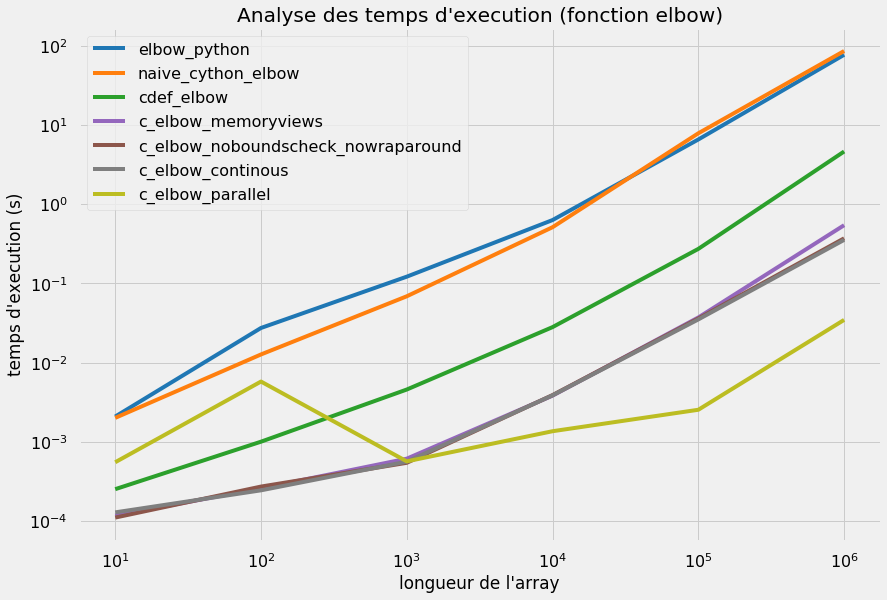

In [12]:

from matplotlib import pyplot as plt
import numpy as np


plt.style.use(['seaborn-poster','fivethirtyeight'])
# plt.style.use(['dark_background', 'presentation'])
x = [10**i for i in array_len_range]

fig, ax = plt.subplots()
NUM_COLORS = len(functions_arrays)
cm = plt.get_cmap('tab10')
ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for i,(function,array) in enumerate(functions_arrays):
    ax.plot(x, array,label=function)

ax.set_title("Analyse des temps d'execution (fonction elbow)")
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')

plt.xlabel ("longueur de l'array")
plt.ylabel ("temps d'execution (s)")
plt.show()